<a href="https://colab.research.google.com/github/vardhanaleti/MNIST-digit-classifier/blob/master/drions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import keras
import os
import cv2
import numpy as np
import glob
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D , Dropout, Add
from keras.models import Model
from keras import backend as K
from keras.preprocessing.image import load_img
from matplotlib import pyplot as plt

In [ ]:
#path with all the images
def read_images(path):
    os.chdir(path)
    images = []
    mat_imgs = []
    for file in sorted(glob.glob("*.jpg")):
        img = cv2.imread(file)
        mat_im = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        #print(file)
        images.append(np.array(img))
        mat_imgs.append(np.array(mat_im))
    return images,mat_imgs

In [ ]:
def read_masks(path):
    l = os.listdir(path)
    lsorted = sorted(l,key=lambda x: int(os.path.splitext(x)[0]))
    images = []
    for file in lsorted:
        img = cv2.imread(path + file)
        #mat_im = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        #print(file)
        images.append(np.array(img))
        #mat_imgs.append(mat_im)
    return images

In [ ]:
imgs,mat = read_images('/content/gdrive/My Drive/auto-encoder/images')

In [ ]:
masks = read_masks('/content/gdrive/My Drive/auto-encoder/masks/')

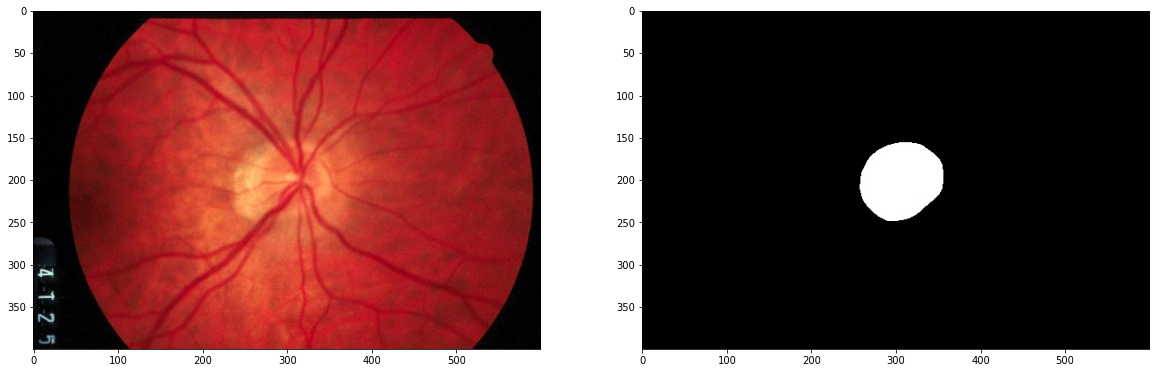

In [ ]:
i = 7
fig,ax = plt.subplots(1,2,figsize = (20,16))
ax[0].imshow(mat[i])
ax[1].imshow(masks[i])

In [ ]:
X = []
Y = []
for i in range(110):
    if(i!=100):
        X.append(mat[i])
        Y.append(masks[i])

In [ ]:
X_train = np.array(X[0:90])/255
X_test = np.array(X[90:])/255

Y_train = np.array(Y[0:90])/255
Y_test = np.array(Y[90:])/255

In [ ]:
def auto_encoder(input_shape):
    
    X_input = Input(input_shape)
    
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(X_input)
    x = MaxPooling2D((2, 2), padding='same')(x)
    temp_1 = x
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    temp_2 = x
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Add()([encoded,x])
    x = Conv2D(32, (3, 3), activation='relu',padding = 'same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Add()[([temp2,x])
    x = Conv2D(16, (3, 3), activation='relu',padding = 'same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Add()[(temp_1,x)]
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(inputs = X_input, outputs = decoded, name = 'auto_encoder')
    return model

In [ ]:
def unet(input_size):
    X_inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(X_inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = X_inputs, outputs = conv10, name = 'unet')
    return model

In [ ]:
input_shape = (400,600,3)
model = auto_encoder(input_shape)

ValueError: ignored

In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy')

In [ ]:
model.summary()

Model: "auto_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 400, 600, 3) 0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 400, 600, 16) 448         input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 200, 300, 16) 0           conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 200, 300, 32) 4640        max_pooling2d_12[0][0]           
_______________________________________________________________________________________

In [ ]:
model.fit(X_train, Y_train,
                epochs=100,
                batch_size=64,
                shuffle=True)

Epoch 1/100
2/2 [==============================] - 1s 525ms/step - loss: 0.7075
Epoch 2/100
2/2 [==============================] - 1s 524ms/step - loss: 0.6639
Epoch 3/100
2/2 [==============================] - 1s 529ms/step - loss: 0.6022
Epoch 4/100
2/2 [==============================] - 1s 513ms/step - loss: 0.4844
Epoch 5/100
2/2 [==============================] - 1s 522ms/step - loss: 0.3255
Epoch 6/100
2/2 [==============================] - 1s 515ms/step - loss: 0.2881
Epoch 7/100
2/2 [==============================] - 1s 519ms/step - loss: 0.3282
Epoch 8/100
2/2 [==============================] - 1s 527ms/step - loss: 0.2757
Epoch 9/100
2/2 [==============================] - 1s 512ms/step - loss: 0.2170
Epoch 10/100
2/2 [==============================] - 1s 506ms/step - loss: 0.1926
Epoch 11/100
2/2 [==============================] - 1s 532ms/step - loss: 0.1743
Epoch 12/100
2/2 [==============================] - 1s 512ms/step - loss: 0.1612
Epoch 13/100
2/2 [===================

In [ ]:
predictions = model.predict(X_test)

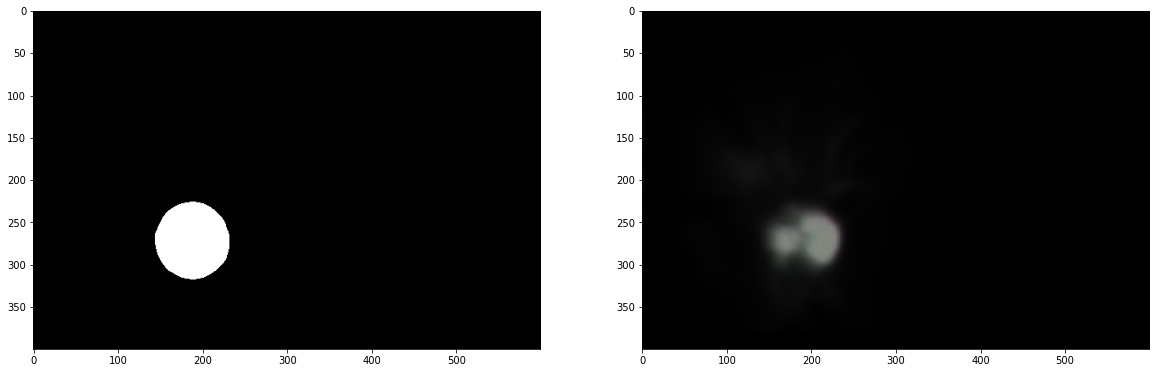

In [ ]:
i = 12
fig,ax = plt.subplots(1,2,figsize = (20,16))
ax[0].imshow(Y_test[i])
ax[1].imshow(predictions[i])